# CS 109A - Intro to Data Science: Project (WIP)
## Predicting Loan Outcomes
## Group: Andrew Greene and David Modjeska
### Harvard University, Fall 2016

In [257]:
import itertools as it
import matplotlib
import matplotlib.cm as cmx
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import os.path as op
import pandas as pd
import re
import scipy as sp
import sklearn.preprocessing as Preprocessing
import datetime

import enchant

from itertools import combinations
from sklearn.cross_validation import KFold as kfold
from sklearn.cross_validation import train_test_split as sk_split
from sklearn.decomposition import TruncatedSVD as tSVD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.ensemble import GradientBoostingClassifier as Boost
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression as Lin_Reg
from sklearn.linear_model import LogisticRegression as Log_Reg
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.svm import SVC

%matplotlib inline
plt.style.use('ggplot') 
from IPython.display import display, HTML

In [258]:
### specify dataset proportion to work with
### save cleaned data to disk if specifying a given proportion for the first time

# load and clean full dataset?
load_full = False

# if not loading and cleaning full dataset, what sample percentage?
sample_percent = 10

## Step 1: Load and Clean Data

### Economic Data

In [259]:
# load CPI data (from https://fred.stlouisfed.org/series/CPIAUCSL/downloaddata)
def load_cpi_data():
    cpi_xls = pd.ExcelFile("datasets/CPIAUCSL.xls")
    cpi_sheet = cpi_xls.sheet_names[0]
    cpi_df = cpi_xls.parse(cpi_sheet, header = None, skiprows = 55)
    cpi_df.columns = ['date', 'cpi']
    
    return cpi_df

In [260]:
# load GDP data (from https://fred.stlouisfed.org/series/GDP/downloaddata)
def load_gdp_data():
    gdp_xls = pd.ExcelFile("datasets/GDP.xls")
    gdp_sheet = gdp_xls.sheet_names[0]
    gdp_df = gdp_xls.parse(gdp_sheet, header = None, skiprows = 20)
    gdp_df.columns = ['date', 'gdp']
    
    return gdp_df

In [261]:
# load unemployment data (from https://fred.stlouisfed.org/series/UNRATE/downloaddata)
def load_unemploy_data():
    unemploy_xls = pd.ExcelFile("datasets/UNRATE.xls")
    unemploy_sheet = unemploy_xls.sheet_names[0]
    unemploy_df = unemploy_xls.parse(unemploy_sheet, header = None, skiprows = 25)
    unemploy_df.columns = ['date', 'unemploy']

    return unemploy_df

In [262]:
### load economic data

econ_filename = "econ_data.csv"

if not op.isfile(econ_filename):
    cpi_df = load_cpi_data()
    gdp_df = load_gdp_data()
    unemploy_df = load_unemploy_data()
    
    econ_data_2 = pd.merge(cpi_df, gdp_df, 'inner')
    econ_data_3 = pd.merge(econ_data_2, unemploy_df, 'inner')
    econ_data_3.to_csv("econ_data.csv", index = False)

else:
    econ_data_3 = pd.read_csv(econ_filename)
    
new_col = econ_data_3["date"].copy()
for index in range(econ_data_3.shape[0]):
    new_col[index] = datetime.datetime.strptime(econ_data_3["date"].values[index], "%Y-%m-%d")
econ_data_3.drop('date', axis = 1, inplace = True)
econ_data_4 = pd.concat((econ_data_3, new_col), axis = 1)

### LC Data

In [263]:
# helper function to select the columns of interest from the data set
def Select_Data(data):
    
    # list columns to select
    features_to_select = ["loan_status", "annual_inc", "earliest_cr_line", "delinq_2yrs", \
                          "emp_length", "home_ownership", "inq_last_6mths", "loan_amnt", \
                         "purpose", "open_acc", "total_acc", "term", "installment", \
                         "revol_bal", "sub_grade", "issue_d"]
    ratios_to_select = ["dti", "revol_util"]
    text_to_select = ["desc"]

    # concatenate selected columns
    data_select = pd.concat(( \
                            data[features_to_select],
                            data[ratios_to_select], \
                            data[text_to_select]), \
                            axis = 1)

    # synthesize new columns, and drop temporary columns
    monthly_inc = (data["annual_inc"] / 12)
    data_select["ipr"] = data["installment"] / monthly_inc # income to payment ratio
    data_select["rir"] = data["revol_bal"] / monthly_inc # revolving to income ratio
    data_select = data_select.drop("installment", axis = 1)
    data_select = data_select.drop("revol_bal", axis = 1)
    
    # rename columns for legibility
    data_select.columns = [
        "loan_status", "annual_income", "earliest_credit", "delinq_2_yrs", \
        "employ_length", "home_owner", "inquiry_6_mos", "loan_amount", \
        "loan_purpose", "open_accounts", "total_accounts", "loan_term", \
        "loan_subgrade", "issue_date", "dti", "revol_util", "description", \
        "ipr", "rir" \
    ]
    
    return data_select

In [264]:
# helper function to filter the data set down to rows of interest
def Filter_Data(data_select):
    
    # set flags for resolved loans
    status_indexes = (data_select["loan_status"] == "Fully Paid") | \
                    (data_select["loan_status"] == "Charged Off")

    # set flags for date range of interest
    earliest_date = pd.to_datetime("2008-01-01")
    data_select["issue_date"] = pd.to_datetime(data_select["issue_date"])
    date_indexes = (data_select["issue_date"] > earliest_date)

    # filter rows per flags of interest
    data_filter = data_select.ix[status_indexes & date_indexes, :].reset_index()
    
    return data_filter

In [265]:
# helper function to clean data - recoding, retyping, pruning, and censoring
def Clean_Data(data_filter):
    data_clean = data_filter.copy()

    # recode loan status as boolean: charged off = True
    data_clean["loan_status"] = data_clean["loan_status"] == "Charged Off"

    # recode loan subgrades from 1 (best) to 35 (worst)
    num_grades = 5
    grade = data_clean["loan_subgrade"].str[0]
    grade = (pd.DataFrame(ord(c) for c in grade) - ord('A')) * num_grades
    sub_grade = data_clean["loan_subgrade"].str[1].astype('int')
    data_clean["loan_subgrade"] =  grade + sub_grade

    # convert earliest credit date to datetime
    data_clean["earliest_credit"] = pd.to_datetime(data_clean["earliest_credit"])

    # prune extra text in loan term 
    data_clean["loan_term"] = data_clean["loan_term"].str.replace(" months", "")

    # prune extra text in employment length, and right-censor
    data_clean["employ_length"] = data_clean["employ_length"].str.replace(" years*", "")
    data_clean["employ_length"] = data_clean["employ_length"].str.replace("10\+", "10")
    data_clean["employ_length"] = data_clean["employ_length"].str.replace("< 1", "0")
    
    # right-censor delinquencies and inquiries
    data_clean["delinq_2_yrs"] = np.clip(data_clean["delinq_2_yrs"], 0, 2)
    data_clean["inquiry_6_mos"] = np.clip(data_clean["inquiry_6_mos"], 0, 3)
        
    return data_clean

In [266]:
# helper function to clean data - filtering nuisance NaNs (not structural NaNs)
def Clean_Data2(data_clean):
    n, p = data_clean.shape
    
    # count nulls by column
    col_nan_pct = data_clean.isnull().sum() / n
    
    # flag columns that have some nuisance nulls
    cols_with_nans = (col_nan_pct > 0.0) & (col_nan_pct < 0.01)
    
    # flag rows that have some nuisance nulls in the flagged columns
    rows_without_nans_flags = data_clean.ix[:, cols_with_nans].notnull()
    
    # index the flagged rows that contain some nuisance nulls
    rows_without_nans_indexes = np.where(rows_without_nans_flags)
    
    # filter the data set to rows that contain no nuisance nulls
    data_clean2 = data_clean.ix[rows_without_nans_indexes[0], :]
    
    return data_clean2

In [267]:
# helper function to pre-process each data subset to get around memory limits
def Prep_Data_Part(index, num_parts, file_prefix, data_all):
    filename = file_prefix + str(index) + ".csv"
    
    # pre-process new data part if the file doesn't already exist
    if not op.isfile(filename):
        n, p = data_all.shape
        
        # pre-process the row range for this data part, avoiding empty data subsets
        start_row = index * (n / num_parts)
        data_part = data_all.ix[range(start_row, start_row + (n / num_parts)), :]
        if data_part.shape[0] > 0:
            data_select = Select_Data(data_part)
            data_filter = Filter_Data(data_select)
            if data_filter.shape[0] > 0:
                data_clean = Clean_Data(data_filter)
                data_clean2 = Clean_Data2(data_clean)
                data_clean2.to_csv(filename, index = False)

In [268]:
# Lending Club (LC) data (from https://www.kaggle.com/wendykan/lending-club-loan-data)
# helper function to pre-process full data set and save new file, 
# or to read pre-processed file if it already exists
def Preprocess_Full_Dataset():
    file_prefix = "./data_parts/loan_clean_part"
    full_clean_data_file = "loan_clean_data.csv"
    num_parts = 30

    # pre-process data set and save result as new file
    if not op.isfile(full_clean_data_file):

        # pre-process and save part files
        data_raw = pd.read_csv("loan.csv")
        for part in range(num_parts):
            Prep_Data_Part(part, num_parts, file_prefix, data_raw)       

        # read and concatenate part files
        data = pd.DataFrame({})
        for part in range(num_parts):
            file_part = file_prefix + str(part) + ".csv"
            if op.isfile(file_part):
                data_part = pd.read_csv(file_part)
                data = pd.concat((data, data_part), axis = 0)

        # save full file
        data = data.reset_index()
        data.to_csv(full_clean_data_file, index = False)

    # read pre-processed full data file
    else:
        data = pd.read_csv(full_clean_data_file)
        
    return data

In [269]:
# helper function to pre-process sampled data set and save new file, 
# or to read pre-processed file if it already exists
def Preprocess_Sample_Dataset():
    sample_clean_data_file = "loan_clean_data_" + str(sample_percent) + "pct.csv"

    # pre-process sample data set and save result as new file
    if not op.isfile(sample_clean_data_file):
        data_raw = pd.read_csv("loan.csv")
        data_sample, data_other = sk_split(data_raw, train_size = sample_percent / 100.0)
        data_select = Select_Data(data_sample)
        data_filter = Filter_Data(data_select)
        data_clean = Clean_Data(data_filter)
        data_clean2 = Clean_Data2(data_clean)
        data_clean2.to_csv(sample_clean_data_file, index = False)

    # read pre-processed sample data file
    else:
        data_clean2 = pd.read_csv(sample_clean_data_file)
        
    return data_clean2

In [270]:
# create or load appropriate version of data set for analysis

if load_full:
    data = Preprocess_Full_Dataset()
    
else:
    data = Preprocess_Sample_Dataset()   

In [271]:
# set boolean and string column data types
data["loan_status"] = data["loan_status"].astype(bool)
data["description"] = data["description"].astype('str')
data["issue_date"] = data["issue_date"].astype('str') # for later conversion to datetime

nan_flags = data["description"].str.match("nan")
data.ix[nan_flags, "description"] = None

# replace all numbers with a token
data["description"] = data["description"].str.replace("[0-9]+", "_number_")

In [272]:
# summarize nulls/NaNs in data columns
# FIX - print only cols with nulls
print
print "Count of nulls in data set by column:\n"
print data.isnull().sum()
print


Count of nulls in data set by column:

index                  0
loan_status            0
annual_income          0
earliest_credit        0
delinq_2_yrs           0
employ_length          0
home_owner             0
inquiry_6_mos          0
loan_amount            0
loan_purpose           0
open_accounts          0
total_accounts         0
loan_term              0
loan_subgrade          0
issue_date             0
dti                    0
revol_util             0
description        16487
ipr                    0
rir                    0
dtype: int64



In [273]:
data.head()

,index,loan_status,annual_income,earliest_credit,delinq_2_yrs,employ_length,home_owner,inquiry_6_mos,loan_amount,loan_purpose,open_accounts,total_accounts,loan_term,loan_subgrade,issue_date,dti,revol_util,description,ipr,rir
0,312482,False,110000.0,1995-08-01,2.0,4,MORTGAGE,0.0,13000.0,debt_consolidation,10.0,33.0,36,2.0,2014-09-01,3.05,18.0,None,0.043460,0.567927
1,813196,False,82000.0,2004-04-01,0.0,3,MORTGAGE,1.0,15000.0,debt_consolidation,12.0,54.0,36,7.0,2015-03-01,16.64,76.6,None,0.071855,2.712878
2,385202,False,55000.0,1998-05-01,0.0,5,RENT,1.0,10000.0,credit_card,11.0,16.0,60,17.0,2014-05-01,20.53,74.5,None,0.052608,2.130109
3,99657,False,80000.0,1996-01-01,0.0,8,MORTGAGE,1.0,9600.0,debt_consolidation,10.0,18.0,36,7.0,2013-08-01,9.69,66.8,None,0.047520,4.299000
4,50008,False,72000.0,1991-06-01,2.0,10,MORTGAGE,3.0,16000.0,debt_consolidation,12.0,39.0,60,17.0,2013-12-01,12.25,70.0,None,0.070607,2.649667


In [274]:
# create new column for first day of quarter that contains issue date
new_col = data["issue_date"].copy()
for index in range(data.shape[0]):
    new_col[index] = datetime.datetime.strptime(data["issue_date"].values[index], 
                                                "%Y-%m-%d").replace(day = 1)
    quarter = (new_col[index].month - 1) // 3
    new_col.values[index] = new_col.values[index].replace(month = (3 * quarter) + 1)
new_col.name = 'issue_quarter'
data = pd.concat((data, new_col), axis = 1)

In [275]:
# join LC and economic data
data = data.merge(right = econ_data_4, how = 'inner', 
                  left_on = "issue_quarter", right_on = "date", 
                  left_index = True).reset_index(drop = True)
data.drop('issue_quarter', axis = 1, inplace = True)
data.drop('date', axis = 1, inplace = True)

In [276]:
# normalize float columns
float_cols = ['dti', 'revol_util', 'ipr', 'rir', 'cpi', 'gdp', 'unemploy']
data[float_cols] = data[float_cols].astype(float)
data[float_cols] = Preprocessing.normalize(data[float_cols]).astype(float)

In [277]:
data.head()

,index,loan_status,annual_income,earliest_credit,delinq_2_yrs,employ_length,home_owner,inquiry_6_mos,loan_amount,loan_purpose,open_accounts,total_accounts,loan_term,loan_subgrade,issue_date,dti,revol_util,description,ipr,rir,cpi,gdp,unemploy
0,312482,False,110000.00,1995-08-01,2.0,4,MORTGAGE,0.0,13000.0,debt_consolidation,10.0,33.0,36,2.0,2014-09-01,0.000174,0.001024,None,0.000002,0.000032,0.013503,0.999908,0.000353
1,352397,False,93000.00,1985-04-01,0.0,10,MORTGAGE,1.0,10000.0,other,14.0,29.0,60,27.0,2014-07-01,0.001314,0.004490,None,0.000002,0.000462,0.013503,0.999898,0.000353
2,345746,False,63000.00,1988-10-01,0.0,10,OWN,2.0,27650.0,debt_consolidation,23.0,52.0,60,17.0,2014-07-01,0.001483,0.002817,None,0.000007,0.000490,0.013503,0.999904,0.000353
3,355686,True,22272.88,2000-02-01,0.0,n/a,RENT,0.0,4200.0,credit_card,16.0,25.0,36,22.0,2014-07-01,0.000908,0.002003,None,0.000005,0.000196,0.013503,0.999906,0.000353
4,337159,False,42000.00,2005-03-01,0.0,3,MORTGAGE,1.0,12000.0,debt_consolidation,10.0,12.0,60,12.0,2014-07-01,0.001389,0.004701,None,0.000005,0.000228,0.013503,0.999897,0.000353


In [278]:
data.describe()

,index,annual_income,delinq_2_yrs,inquiry_6_mos,loan_amount,open_accounts,total_accounts,loan_term,loan_subgrade,dti,revol_util,ipr,rir,cpi,gdp,unemploy
count,25384.000000,2.538400e+04,25384.000000,25384.000000,25384.000000,25384.000000,25384.000000,25384.000000,25384.000000,25384.000000,25384.000000,2.538400e+04,25384.000000,25384.000000,25384.000000,25384.000000
mean,252151.133037,7.235704e+04,0.210566,0.813938,13551.981563,10.925938,25.015955,41.338166,10.966475,0.000989,0.003266,4.696754e-06,0.000160,0.013905,0.999896,0.000442
std,215557.498375,7.548228e+04,0.515127,0.960969,8114.870332,4.869299,11.751599,9.981177,6.643957,0.000460,0.001513,2.442382e-06,0.000132,0.000412,0.000008,0.000095
min,0.000000,4.800000e+03,0.000000,0.000000,725.000000,1.000000,2.000000,36.000000,2.000000,0.000000,0.000000,2.108718e-08,0.000000,0.013056,0.999864,0.000274
25%,96982.500000,4.500000e+04,0.000000,0.000000,7200.000000,8.000000,16.000000,36.000000,7.000000,0.000640,0.002165,2.823275e-06,0.000071,0.013680,0.999891,0.000359
50%,196861.000000,6.198950e+04,0.000000,1.000000,12000.000000,10.000000,23.000000,36.000000,12.000000,0.000972,0.003354,4.371255e-06,0.000131,0.013895,0.999896,0.000436
75%,361326.500000,8.600000e+04,0.000000,1.000000,18431.250000,13.000000,32.000000,36.000000,17.000000,0.001321,0.004442,6.272437e-06,0.000214,0.014213,0.999902,0.000505
max,887346.000000,8.706582e+06,2.000000,3.000000,35000.000000,53.000000,102.000000,60.000000,32.000000,0.003135,0.007174,1.797267e-05,0.003202,0.014926,0.999915,0.000686


## Step 2: Explore Data

In [280]:
image_counter = 0

In [281]:
def good_bad_quantile_plot(data, column):
    global image_counter
    
    col_data = data[column]
    nulls = pd.isnull(col_data)
    col_data = col_data[~nulls]
    #if col_data.dtype == '<M8[ns]':
    #    col_data = col_data.dt.strftime('%Y-%m')
    
    defaults = data['loan_status'] == True  # for now TODO

    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    # 45-degree line
    ax.plot(
        [min(col_data), max(col_data)],
        [min(col_data), max(col_data)],
        c='k'
    )
    # Actual qq plot
    ax.plot(
        list(col_data[~defaults].quantile(q=np.arange(0.0, 1.005, .005))),
        list(col_data[defaults].quantile(q=np.arange(0.0, 1.0005, .005))),
        c='r'
    )
    ax.scatter(
        list(col_data[~defaults].quantile(q=np.arange(0.0, 1.1, .1))),
        list(col_data[defaults].quantile(q=np.arange(0.0, 1.1, .1))),
        c='r'
    )
    
    ax.set_title("QQ plot for " + column)
    ax.set_xlabel('Good loans')
    ax.set_ylabel('Bad loans')
    
    plt.show()
    
    fig.savefig('Images/img_' + str(image_counter) + '.png', bbox_inches='tight')
    image_counter += 1

In [282]:
# print dataset shape, and widen pandas dataframe display
n, p = data.shape
pd.set_option('display.max_columns', p)

print
print "The shape of the data is", data.shape
print


The shape of the data is (25384, 23)



In [283]:
# display top rows of data set
print
data.head()

,index,loan_status,annual_income,earliest_credit,delinq_2_yrs,employ_length,home_owner,inquiry_6_mos,loan_amount,loan_purpose,open_accounts,total_accounts,loan_term,loan_subgrade,issue_date,dti,revol_util,description,ipr,rir,cpi,gdp,unemploy
0,312482,False,110000.00,1995-08-01,2.0,4,MORTGAGE,0.0,13000.0,debt_consolidation,10.0,33.0,36,2.0,2014-09-01,0.000174,0.001024,None,0.000002,0.000032,0.013503,0.999908,0.000353
1,352397,False,93000.00,1985-04-01,0.0,10,MORTGAGE,1.0,10000.0,other,14.0,29.0,60,27.0,2014-07-01,0.001314,0.004490,None,0.000002,0.000462,0.013503,0.999898,0.000353
2,345746,False,63000.00,1988-10-01,0.0,10,OWN,2.0,27650.0,debt_consolidation,23.0,52.0,60,17.0,2014-07-01,0.001483,0.002817,None,0.000007,0.000490,0.013503,0.999904,0.000353
3,355686,True,22272.88,2000-02-01,0.0,n/a,RENT,0.0,4200.0,credit_card,16.0,25.0,36,22.0,2014-07-01,0.000908,0.002003,None,0.000005,0.000196,0.013503,0.999906,0.000353
4,337159,False,42000.00,2005-03-01,0.0,3,MORTGAGE,1.0,12000.0,debt_consolidation,10.0,12.0,60,12.0,2014-07-01,0.001389,0.004701,None,0.000005,0.000228,0.013503,0.999897,0.000353


In [284]:
# summarize data set
print
data.describe()

,index,annual_income,delinq_2_yrs,inquiry_6_mos,loan_amount,open_accounts,total_accounts,loan_term,loan_subgrade,dti,revol_util,ipr,rir,cpi,gdp,unemploy
count,25384.000000,2.538400e+04,25384.000000,25384.000000,25384.000000,25384.000000,25384.000000,25384.000000,25384.000000,25384.000000,25384.000000,2.538400e+04,25384.000000,25384.000000,25384.000000,25384.000000
mean,252151.133037,7.235704e+04,0.210566,0.813938,13551.981563,10.925938,25.015955,41.338166,10.966475,0.000989,0.003266,4.696754e-06,0.000160,0.013905,0.999896,0.000442
std,215557.498375,7.548228e+04,0.515127,0.960969,8114.870332,4.869299,11.751599,9.981177,6.643957,0.000460,0.001513,2.442382e-06,0.000132,0.000412,0.000008,0.000095
min,0.000000,4.800000e+03,0.000000,0.000000,725.000000,1.000000,2.000000,36.000000,2.000000,0.000000,0.000000,2.108718e-08,0.000000,0.013056,0.999864,0.000274
25%,96982.500000,4.500000e+04,0.000000,0.000000,7200.000000,8.000000,16.000000,36.000000,7.000000,0.000640,0.002165,2.823275e-06,0.000071,0.013680,0.999891,0.000359
50%,196861.000000,6.198950e+04,0.000000,1.000000,12000.000000,10.000000,23.000000,36.000000,12.000000,0.000972,0.003354,4.371255e-06,0.000131,0.013895,0.999896,0.000436
75%,361326.500000,8.600000e+04,0.000000,1.000000,18431.250000,13.000000,32.000000,36.000000,17.000000,0.001321,0.004442,6.272437e-06,0.000214,0.014213,0.999902,0.000505
max,887346.000000,8.706582e+06,2.000000,3.000000,35000.000000,53.000000,102.000000,60.000000,32.000000,0.003135,0.007174,1.797267e-05,0.003202,0.014926,0.999915,0.000686


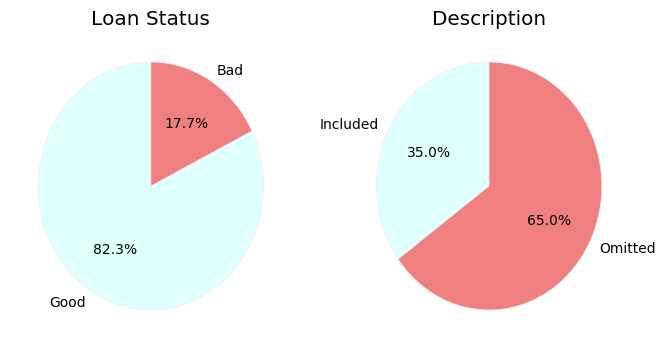

In [285]:
### plot description-related variables as pie charts
n, p = data.shape
fig = plt.figure(figsize = (8, 4))

# loan status
num_good = (data["loan_status"] == False).sum()
num_bad = n - num_good
pie_1 = fig.add_subplot(121)
pie_1.pie([num_good, num_bad], 
          labels = ["Good", "Bad"],
          colors = ["lightcyan", "lightcoral"],
         autopct = "%1.1f%%", startangle = 90)
pie_1.set_title("Loan Status")

# description included
num_include = (data["description"].notnull()).sum()
num_omit = n - num_include
pie_3 = fig.add_subplot(122)
pie_3.pie([num_include, num_omit], 
          labels = ["Included", "Omitted"],
          colors = ["lightcyan", "lightcoral"],
         autopct = "%1.1f%%", startangle = 90)
pie_3.set_title("Description")

plt.show()

fig.savefig('Images/img_' + str(image_counter) + '.png', bbox_inches='tight')
image_counter += 1

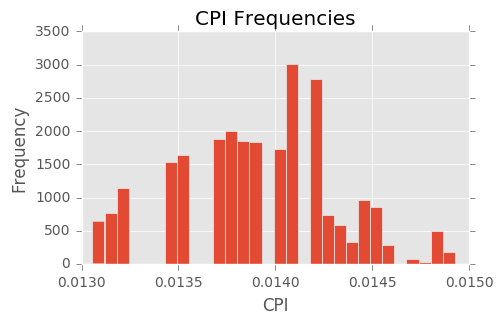

In [286]:
# plot histogram of CPI
fig = plt.figure(figsize = (5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.hist(data['cpi'], bins = 30)
ax.set_title("CPI Frequencies")
ax.set_xlabel("CPI")
ax.set_ylabel("Frequency")
plt.show()

fig.savefig('Images/img_' + str(image_counter) + '.png', bbox_inches='tight')
image_counter += 1

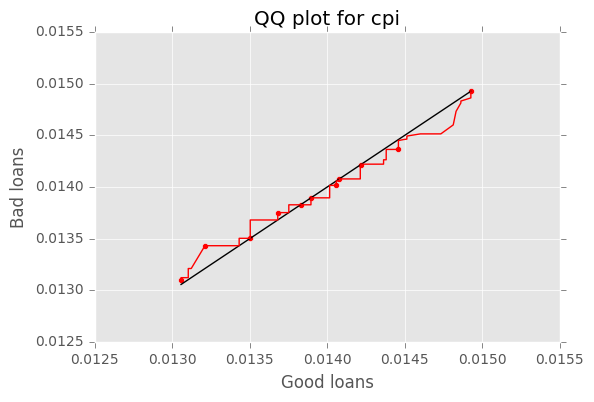

In [287]:
good_bad_quantile_plot(data, 'cpi')

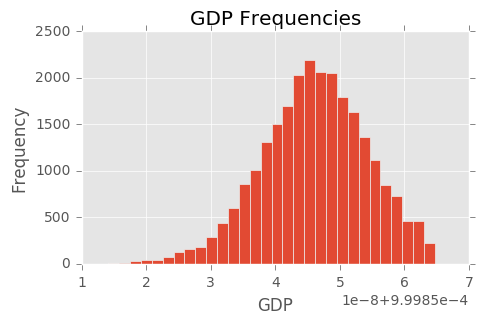

In [288]:
# plot histogram of GDP
fig = plt.figure(figsize = (5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.hist(data['gdp'] / 1000.0, bins = 30)
ax.set_title("GDP Frequencies")
ax.set_xlabel("GDP")
ax.set_ylabel("Frequency")
plt.show()

fig.savefig('Images/img_' + str(image_counter) + '.png', bbox_inches='tight')
image_counter += 1

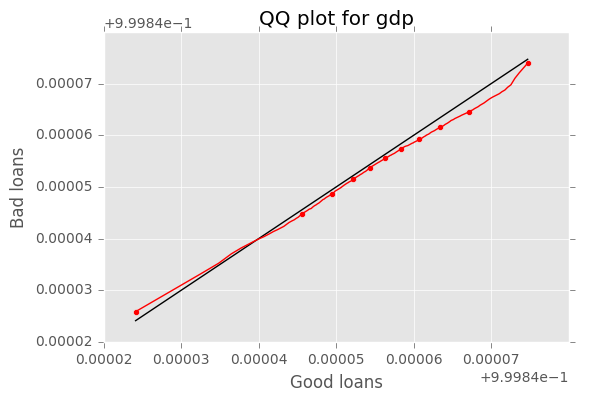

In [289]:
good_bad_quantile_plot(data, 'gdp')

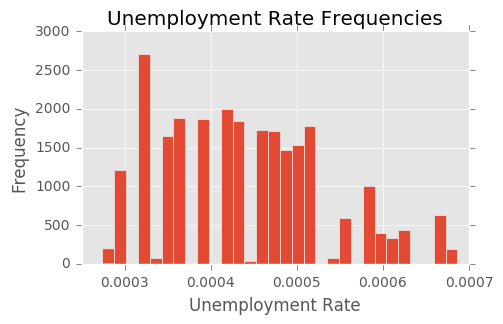

In [290]:
# plot histogram of unemployment rate
fig = plt.figure(figsize = (5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.hist(data['unemploy'], bins = 30)
ax.set_title("Unemployment Rate Frequencies")
ax.set_xlabel("Unemployment Rate")
ax.set_ylabel("Frequency")
plt.show()

fig.savefig('Images/img_' + str(image_counter) + '.png', bbox_inches='tight')
image_counter += 1

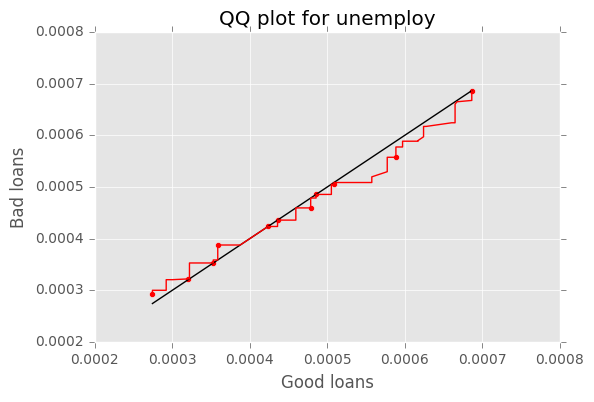

In [291]:
good_bad_quantile_plot(data, 'unemploy')

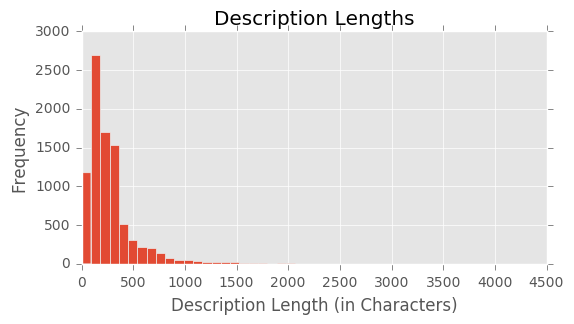

In [292]:
# visualize description lengths in characters
fig = plt.figure(figsize = (6, 3))

description_flags = data["description"].notnull()
descriptions = data.ix[description_flags, "description"]
description_lengths = descriptions.str.len()
data['desc_len'] = description_lengths
ax1 = fig.add_subplot(111)
ax1.hist(description_lengths, bins = 50)
ax1.set_title("Description Lengths")
ax1.set_xlabel("Description Length (in Characters)")
ax1.set_ylabel("Frequency")

plt.show()

fig.savefig('Images/img_' + str(image_counter) + '.png', bbox_inches='tight')
image_counter += 1

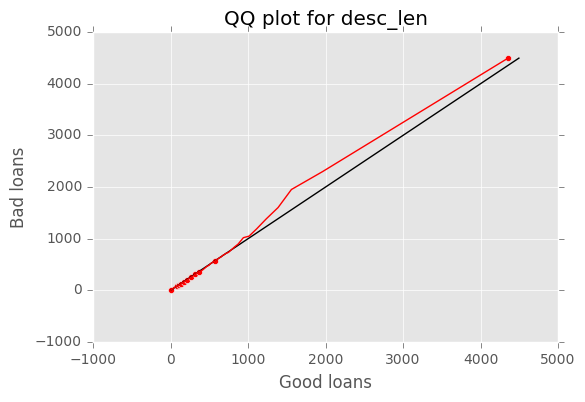

In [293]:
data_desc = data[description_flags]
good_bad_quantile_plot(data_desc, 'desc_len')

In [294]:
description_lengths_df = pd.DataFrame(description_lengths)
description_lengths_df.columns = ["description_length_chars"]
description_lengths_df.describe()

,description_length_chars
count,8897.000000
mean,291.765202
std,312.596608
min,1.000000
25%,120.000000
50%,208.000000
75%,344.000000
max,4493.000000


In [295]:
# Are descriptions correlated with inclusion of descriptions?
data_corr = pd.concat((data["loan_status"], description_flags), axis = 1)
corr_matrix = np.corrcoef(data_corr.T)

print
print "Loan status is not correlated with the inclusion of descriptions:\n"
print corr_matrix
print


Loan status is not correlated with the inclusion of descriptions:

[[ 1.         -0.01349909]
 [-0.01349909  1.        ]]



### Text Analysis

In [378]:
# extract and pre-process loan description and loan_status for NLP
data_nlp = data.loc[description_flags, :].copy()
data_nlp["description"] = data_nlp["description"].str.replace("Borrower.* > ", "")

In [379]:
### set up stemming

from nltk.stem import SnowballStemmer

stemmer = SnowballStemmer(language = 'english', ignore_stopwords = True)
analyzer = TfidfVectorizer().build_analyzer()

def stemmed_words(doc):
    return (stemmer.stem(w) for w in analyzer(doc))

def take(n, seq):
    seq = iter(seq)
    result = []
    try:
        for i in range(n):
            result.append(seq.next())
    except StopIteration:
        pass
    
    return result

In [380]:
# stem words in Description field
for index in range(data_nlp.shape[0]):
    data_nlp['description'].values[index] = \
        " ".join(take(1000, stemmed_words(data_nlp['description'].values[index])))

In [381]:
# create n-grams from loan description
vectorizer = CountVectorizer(stop_words = 'english', ngram_range = (1, 1))
desc_matrix = vectorizer.fit_transform(data_nlp['description'].values)
n, p = desc_matrix.shape
print desc_matrix.shape

(8897, 5613)


In [382]:
# apply SVD to document-term matrix
tsvd = tSVD(n_components = 100)
desc_matrix_reduce = tsvd.fit_transform(desc_matrix)

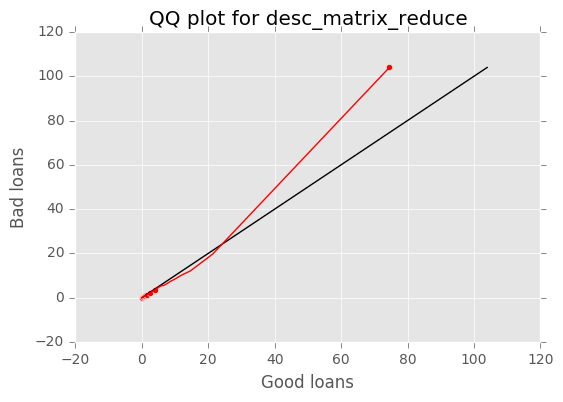

In [383]:
data_nlp['desc_matrix_reduce'] = desc_matrix_reduce[:, 0]
good_bad_quantile_plot(data_nlp, 'desc_matrix_reduce')

In [384]:
# print descriptive information about n-grams
feature_names = np.array(vectorizer.get_feature_names()).reshape(-1, 1)
print "Number of descriptions and terms:", n, p
print
print "Sample terms:", 
pd.DataFrame(feature_names[:10, 0])

Number of descriptions and terms: 8897 5613

Sample terms:

,0
0,_number_
1,_number_acr
2,_number_api
3,_number_b
4,_number_ba
5,_number_bn
6,_number_br
7,_number_d
8,_number_day
9,_number_dvd


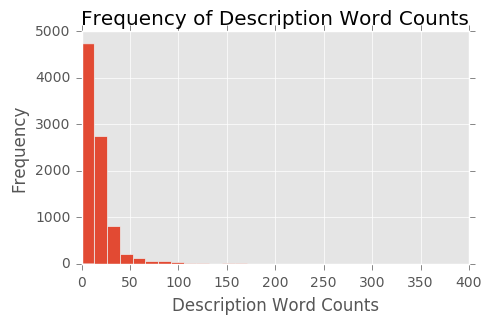

In [385]:
data_nlp['desc_word_count'] = desc_matrix.sum(axis = 1)

# plot histogram of word counts by description
fig = plt.figure(figsize = (5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.hist(data_nlp['desc_word_count'].values, bins = 30)
ax.set_title("Frequency of Description Word Counts")
ax.set_xlabel("Description Word Counts")
ax.set_ylabel("Frequency")
plt.show()

fig.savefig('Images/img_' + str(image_counter) + '.png', bbox_inches='tight')
image_counter += 1

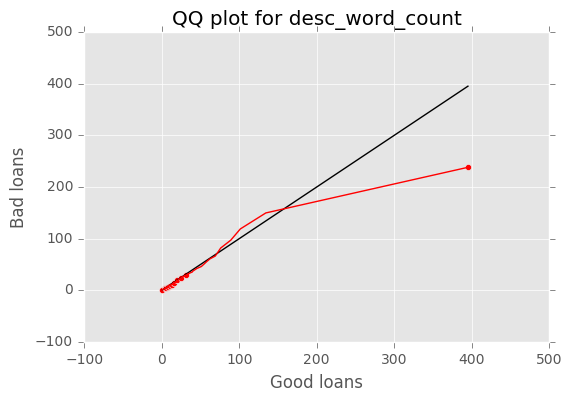

In [386]:
good_bad_quantile_plot(data_nlp, "desc_word_count")

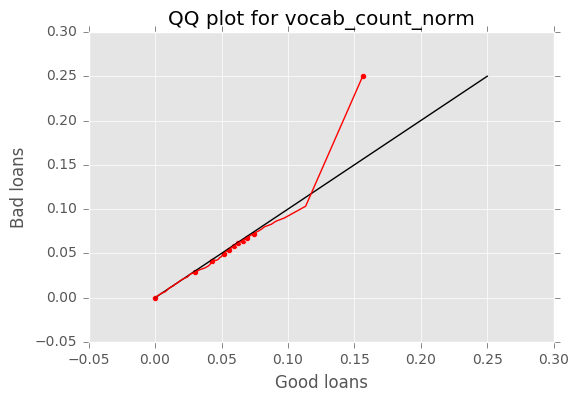

In [387]:
data_nlp['vocab_count'] = (desc_matrix > 0).sum(axis=1)

data_nlp['vocab_count_norm'] = data_nlp['vocab_count'] \
    / data_nlp['desc_len'].astype(float) 
good_bad_quantile_plot(data_nlp, "vocab_count_norm")

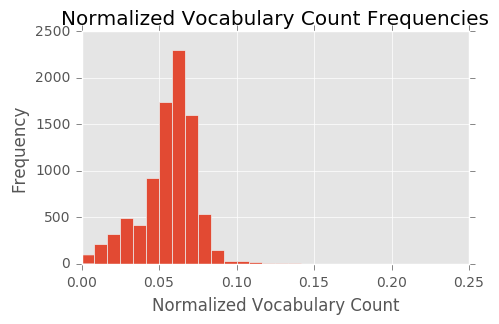

In [388]:
# plot histogram of vocabulary richness
fig = plt.figure(figsize = (5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.hist(data_nlp['vocab_count_norm'], bins = 30)
ax.set_title("Normalized Vocabulary Count Frequencies")
ax.set_xlabel("Normalized Vocabulary Count")
ax.set_ylabel("Frequency")
plt.show()

fig.savefig('Images/img_' + str(image_counter) + '.png', bbox_inches='tight')
image_counter += 1

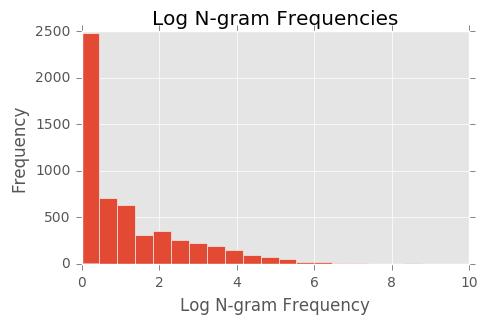

In [389]:
ngram_counts = np.log(desc_matrix.sum(axis = 0))

# plot histogram of n-gram frequency
fig = plt.figure(figsize = (5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.hist(ngram_counts.transpose(), bins = 20)
ax.set_title("Log N-gram Frequencies")
ax.set_xlabel("Log N-gram Frequency")
ax.set_ylabel("Frequency")
plt.show()

fig.savefig('Images/img_' + str(image_counter) + '.png', bbox_inches='tight')
image_counter += 1

In [390]:
# split term matrix into defaulted vs. fully repaid
mask = data_nlp["loan_status"].values == False
bad_term_matrix = desc_matrix[mask]
good_term_matrix = desc_matrix[~mask]

all_term_dict = zip(vectorizer.get_feature_names(),
    np.asarray(desc_matrix.sum(axis = 0)).ravel())
all_term_dict_df = pd.DataFrame(all_term_dict).sort_values(by = [1], \
                                                                   ascending = False)
bad_term_dict = zip(vectorizer.get_feature_names(),
    np.asarray(bad_term_matrix.sum(axis = 0)).ravel())
bad_term_dict_df = pd.DataFrame(bad_term_dict).sort_values(by = [1], \
                                                                   ascending = False)
good_term_dict = zip(vectorizer.get_feature_names(),
    np.asarray(good_term_matrix.sum(axis = 0)).ravel())
good_term_dict_df = pd.DataFrame(good_term_dict).sort_values(by = [1], \
                                                                 ascending = False)

top_bad_dict_df = bad_term_dict_df.iloc[:125, :]
top_good_dict_df = good_term_dict_df.iloc[:125, :]

bad_only_df = pd.DataFrame(list(set(top_bad_dict_df[0]) - set(top_good_dict_df[0])))
good_only_df = pd.DataFrame(list(set(top_good_dict_df[0]) - set(top_bad_dict_df[0])))

In [391]:
print
print "Most Frequent Terms in Descriptions of All Loans:"
all_term_dict_df.head(20)


Most Frequent Terms in Descriptions of All Loans:


,0,1
623,br,10328
0,_number_,8984
1222,credit,5893
2945,loan,5398
3614,pay,5323
760,card,5260
1333,debt,4199
3632,payment,3091
1103,consolid,2827
3244,month,2334


In [392]:
print
print "Most Frequent Terms Only in Descriptions of Defaulted Loans:"
bad_only_df


Most Frequent Terms Only in Descriptions of Defaulted Loans:


,0
0,pleas
1,term
2,appreci
3,student
4,low
5,excel
6,question
7,cash
8,know
9,way


In [393]:
print
print "Most Frequent Terms Only in Descriptions of Fully Repaid Loans:"
good_only_df


Most Frequent Terms Only in Descriptions of Fully Repaid Loans:


,0
0,everyth
1,insur
2,extra
3,feel
4,offer
5,realli
6,thing
7,repay
8,instead
9,opportun


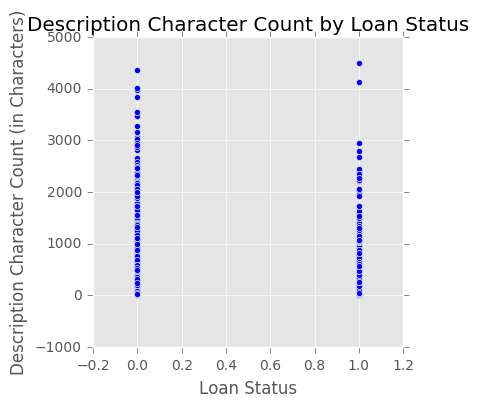

In [394]:
fig = plt.figure(figsize = (4, 4))
ax1 = fig.add_subplot(1, 1, 1)
ax1.scatter(data_nlp['loan_status'], data_nlp['desc_len'])
ax1.set_title("Description Character Count by Loan Status")
ax1.set_xlabel("Loan Status")
ax1.set_ylabel("Description Character Count (in Characters)")
plt.show()

fig.savefig('Images/img_' + str(image_counter) + '.png', bbox_inches='tight')
image_counter += 1

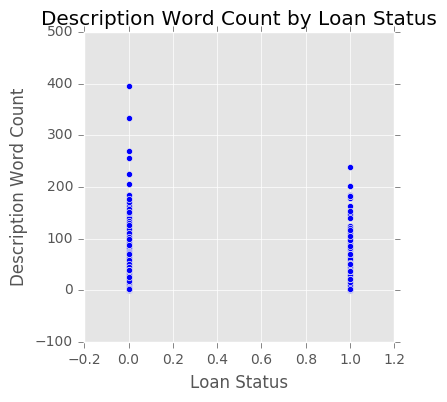

In [395]:
fig = plt.figure(figsize = (4, 4))
ax1 = fig.add_subplot(1, 1, 1)
ax1.scatter(data_nlp['loan_status'], data_nlp['desc_word_count'])
ax1.set_title("Description Word Count by Loan Status")
ax1.set_xlabel("Loan Status")
ax1.set_ylabel("Description Word Count")
plt.show()

fig.savefig('Images/img_' + str(image_counter) + '.png', bbox_inches='tight')
image_counter += 1

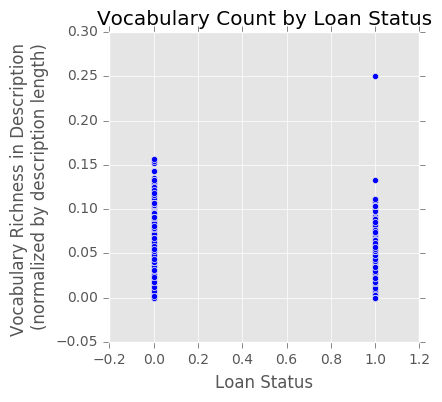

In [396]:
fig = plt.figure(figsize = (4, 4))
ax1 = fig.add_subplot(1, 1, 1)
ax1.scatter(data_nlp['loan_status'], data_nlp['vocab_count_norm'])
ax1.set_title("Vocabulary Count by Loan Status")
ax1.set_xlabel("Loan Status")
ax1.set_ylabel("Vocabulary Richness in Description \n(normalized by description length)")
plt.show()

fig.savefig('Images/img_' + str(image_counter) + '.png', bbox_inches='tight')
image_counter += 1

In [397]:
### count misspellings

d = enchant.Dict("en_US")

num_terms = all_term_dict_df.shape[0]
misspellings = np.zeros(num_terms)
for index in range(num_terms):
    misspellings[index] = not d.check(all_term_dict_df.iloc[index, 0])

desc_matrix_misspell = desc_matrix[:, misspellings > 0]
data_nlp['misspell_count'] = desc_matrix_misspell.sum(axis=1)

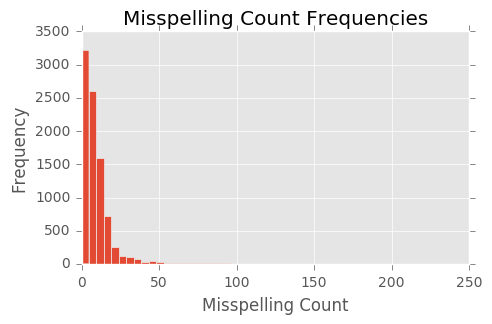

In [398]:
# plot histogram of misspelling counts
fig = plt.figure(figsize = (5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.hist(data_nlp['misspell_count'], bins = 50)
ax.set_title("Misspelling Count Frequencies")
ax.set_xlabel("Misspelling Count")
ax.set_ylabel("Frequency")
plt.show()

fig.savefig('Images/img_' + str(image_counter) + '.png', bbox_inches='tight')
image_counter += 1

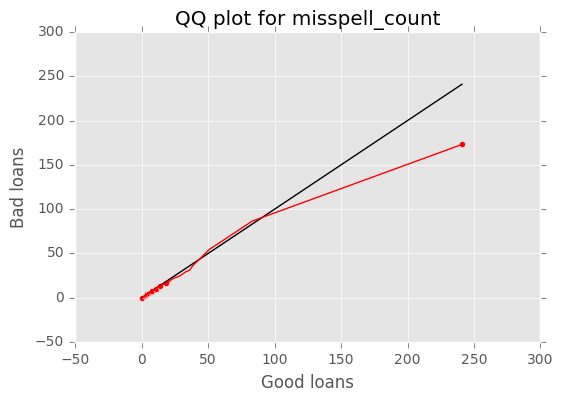

In [399]:
good_bad_quantile_plot(data_nlp, "misspell_count")

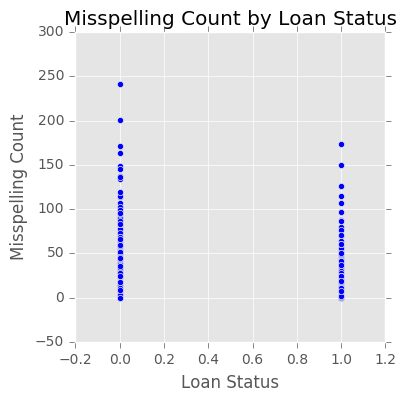

In [400]:
fig = plt.figure(figsize = (4, 4))
ax1 = fig.add_subplot(1, 1, 1)
ax1.scatter(data_nlp['loan_status'], data_nlp['misspell_count'])
ax1.set_title("Misspelling Count by Loan Status")
ax1.set_xlabel("Loan Status")
ax1.set_ylabel("Misspelling Count")
plt.show()

fig.savefig('Images/img_' + str(image_counter) + '.png', bbox_inches='tight')
image_counter += 1

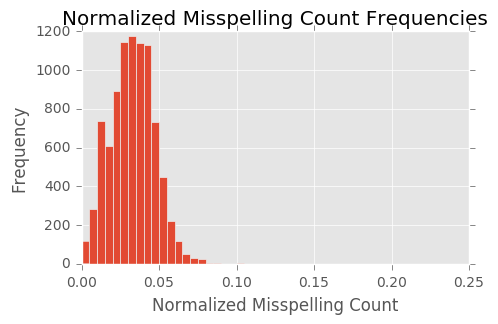

In [401]:
data_nlp['misspell_count_norm'] = data_nlp['misspell_count'] \
    / data_nlp['desc_len'].astype(float) 

# plot histogram of normalized misspelling counts
fig = plt.figure(figsize = (5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.hist(data_nlp['misspell_count_norm'], bins = 50)
ax.set_title("Normalized Misspelling Count Frequencies")
ax.set_xlabel("Normalized Misspelling Count")
ax.set_ylabel("Frequency")
plt.show()

fig.savefig('Images/img_' + str(image_counter) + '.png', bbox_inches='tight')
image_counter += 1

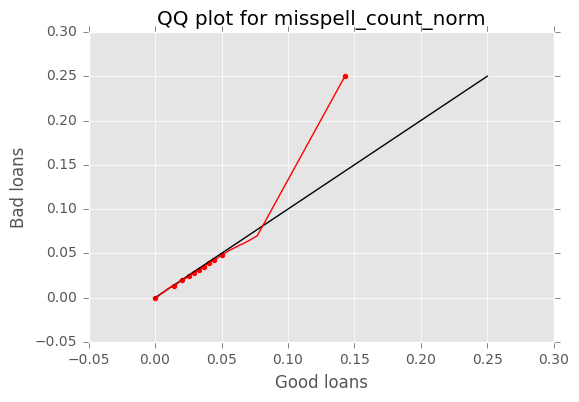

In [402]:
good_bad_quantile_plot(data_nlp, "misspell_count_norm")

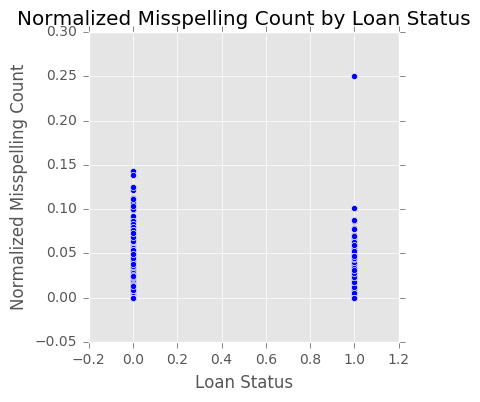

In [403]:
fig = plt.figure(figsize = (4, 4))
ax1 = fig.add_subplot(1, 1, 1)
ax1.scatter(data_nlp['loan_status'], data_nlp['misspell_count_norm'])
ax1.set_title("Normalized Misspelling Count by Loan Status")
ax1.set_xlabel("Loan Status")
ax1.set_ylabel("Normalized Misspelling Count")
plt.show()

fig.savefig('Images/img_' + str(image_counter) + '.png', bbox_inches='tight')
image_counter += 1

In [404]:
data_nlp.describe()

,index,annual_income,delinq_2_yrs,inquiry_6_mos,loan_amount,open_accounts,total_accounts,loan_term,loan_subgrade,dti,revol_util,ipr,rir,cpi,gdp,unemploy,desc_len,desc_matrix_reduce,desc_word_count,vocab_count,vocab_count_norm,misspell_count,misspell_count_norm
count,8897.000000,8.897000e+03,8897.000000,8897.000000,8897.000000,8897.000000,8897.000000,8897.000000,8897.000000,8897.000000,8897.000000,8.897000e+03,8897.000000,8897.000000,8897.000000,8897.000000,8897.000000,8897.000000,8897.000000,8897.000000,8897.000000,8897.000000,8897.000000
mean,143786.420142,7.090605e+04,0.170619,0.846577,13043.239294,10.426885,24.006519,40.370012,9.871755,0.000970,0.003403,4.827371e-06,0.000166,0.014195,0.999891,0.000506,291.765202,1.876563,17.621670,14.708666,0.056102,9.617287,0.032753
std,111312.166513,6.202102e+04,0.467587,0.980221,7771.326754,4.525168,11.256691,9.262447,6.472450,0.000457,0.001590,2.526603e-06,0.000136,0.000290,0.000007,0.000077,312.596608,3.392841,20.028679,13.203184,0.018133,12.149168,0.014518
min,0.000000,4.800000e+03,0.000000,0.000000,725.000000,1.000000,2.000000,36.000000,2.000000,0.000000,0.000000,6.903459e-08,0.000000,0.013211,0.999864,0.000320,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,36230.000000,4.400000e+04,0.000000,0.000000,7175.000000,7.000000,16.000000,36.000000,7.000000,0.000625,0.002268,2.893658e-06,0.000075,0.014015,0.999887,0.000459,120.000000,0.653846,7.000000,6.000000,0.047619,3.000000,0.022642
50%,156805.000000,6.000000e+04,0.000000,1.000000,11500.000000,10.000000,23.000000,36.000000,7.000000,0.000956,0.003544,4.499627e-06,0.000139,0.014213,0.999892,0.000505,208.000000,0.983742,13.000000,11.000000,0.059322,6.000000,0.032710
75%,203127.000000,8.500000e+04,0.000000,1.000000,18000.000000,13.000000,31.000000,36.000000,12.000000,0.001300,0.004644,6.438424e-06,0.000221,0.014380,0.999896,0.000557,344.000000,1.907830,22.000000,19.000000,0.067194,12.000000,0.042301
max,881386.000000,3.900000e+06,2.000000,3.000000,35000.000000,48.000000,82.000000,60.000000,32.000000,0.002154,0.006951,1.797267e-05,0.003082,0.014926,0.999907,0.000686,4493.000000,103.958081,395.000000,210.000000,0.250000,241.000000,0.250000


### Create NLP Features

In [405]:
#@@ create TF-IDF term matrices for two loan outcomes separately

# split data
data_nlp_2 = data_nlp[['description', 'loan_status']]
good_flags = data_nlp_2['loan_status'] == True
good_nlp = data_nlp_2.loc[good_flags, :]
bad_nlp = data_nlp_2.loc[~good_flags, :]

In [406]:
# compute matrices
vectorizer_good = TfidfVectorizer(stop_words = 'english', ngram_range = (1, 1), norm = None,
                                 use_idf = True)
vectorizer_bad = TfidfVectorizer(stop_words = 'english', ngram_range = (1, 1), norm = None,
                                use_idf = True)
good_matrix = vectorizer_good.fit_transform(good_nlp['description'].values)
bad_matrix = vectorizer_bad.fit_transform(bad_nlp['description'].values)

In [407]:
# sum term scores
good_term_scores = good_matrix.sum(axis = 0)
bad_term_scores = bad_matrix.sum(axis = 0)

good_term_scores = Preprocessing.normalize(good_term_scores, axis = 1)
bad_term_scores = Preprocessing.normalize(bad_term_scores, axis = 1)

In [408]:
# get feature names
good_terms = vectorizer_good.get_feature_names()
bad_terms = vectorizer_bad.get_feature_names()

In [409]:
### calculate absolute differences between normalized term scores

n_good = len(good_terms)
n_bad = len(bad_terms)

good_diffs = np.zeros(n_good)
bad_diffs = np.zeros(n_bad)

# consider all words in good loans
for good_term in range(n_good):
    try: 
        match_index = bad_terms.index(good_terms[good_term])
        good_diffs[good_term] = np.abs(good_term_scores[0, good_term] - 
                                       bad_term_scores[0, match_index])
    except ValueError:
        temp = 0
        #good_diffs[good_term] = np.abs(good_term_scores[0, good_term])

# # only consider words uniquely in bad loans, since matches already considered above in loop
# for bad_term in range(n_bad):
#     try:
#         match_index = good_terms.index(bad_terms[bad_term])
#         bad_diffs[bad_term] = -1
#     except ValueError:
#         bad_diffs[bad_term] = np.abs(bad_term_scores[0, bad_term])

In [410]:
### find top different terms

good_diffs_df = pd.DataFrame({'diffs': good_diffs, 'terms': good_terms})
bad_diffs_df = pd.DataFrame({'diffs': bad_diffs, 'terms': bad_terms})

diffs_df = pd.concat((good_diffs_df, bad_diffs_df), axis = 0)
diffs_df_sort = diffs_df.sort_values(by = 'diffs', ascending = False)
diffs_df_sort.head(20)

,diffs,terms
1765,0.022155,rate
311,0.021114,busi
1467,0.018258,need
473,0.016737,consolid
1071,0.016699,help
1275,0.016206,lend
16,0.015285,abl
425,0.014968,com
410,0.014535,club
2470,0.014149,year


In [411]:
### add term flags to data as new features

num_top_diffs = 30
diff_indexes = np.zeros(num_top_diffs).astype(int)
for diff in range(num_top_diffs):
    match_index = np.where(feature_names == diffs_df_sort.iloc[diff, 1])[0]
    diff_indexes[diff] = match_index
    
count_cols = desc_matrix[:, diff_indexes]
count_cols_bool = count_cols > 0.0
count_col_names = feature_names[diff_indexes, 0].astype(str)
count_cols_df = pd.DataFrame(count_cols.toarray(), columns = count_col_names)

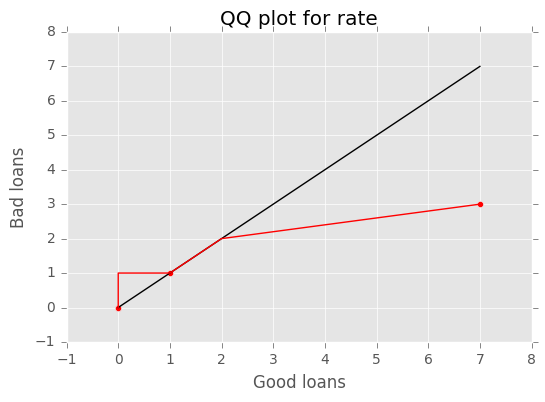

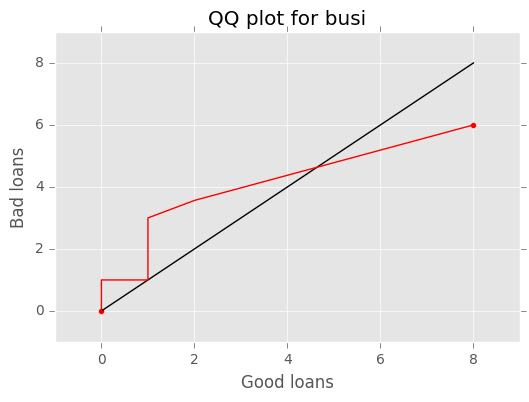

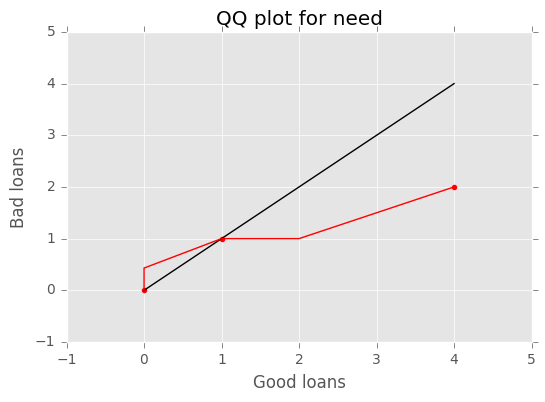

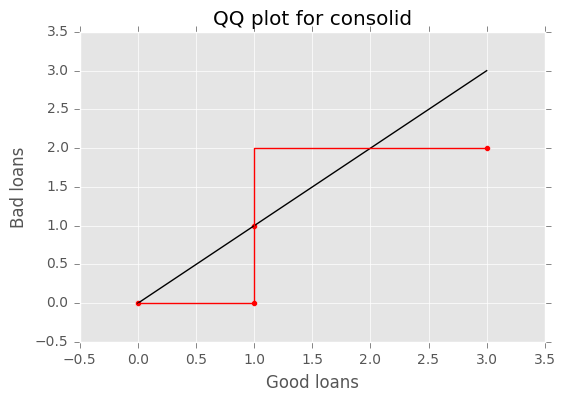

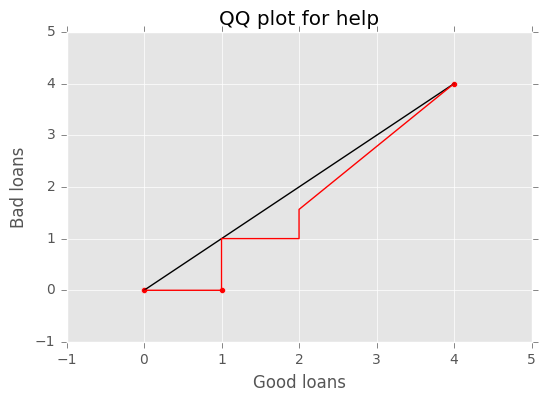

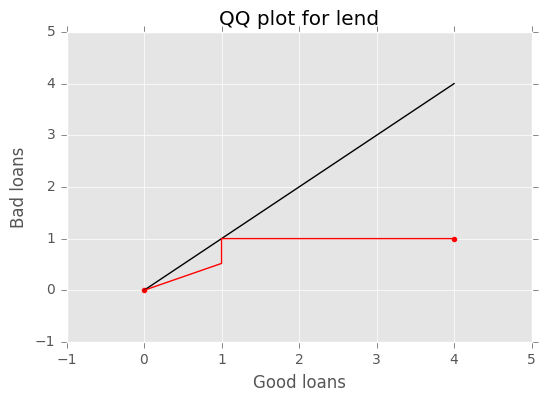

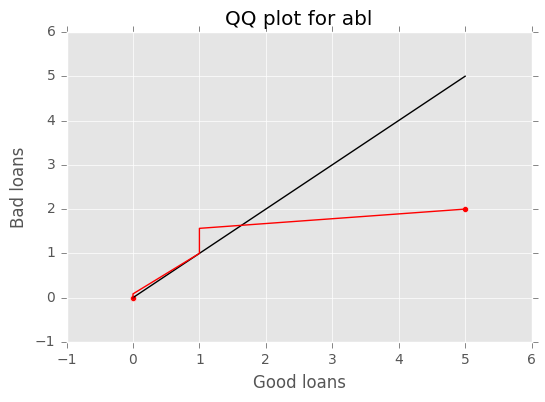

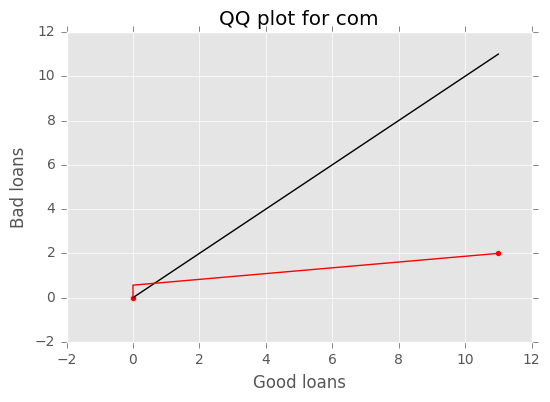

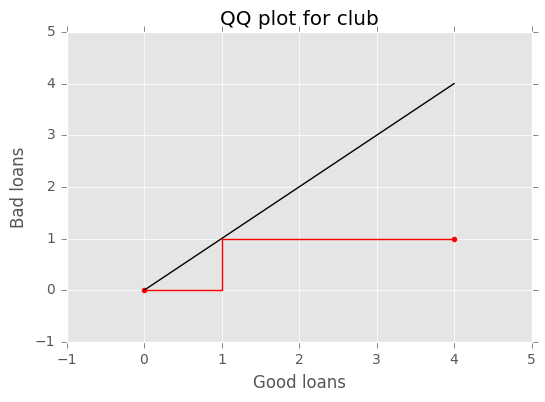

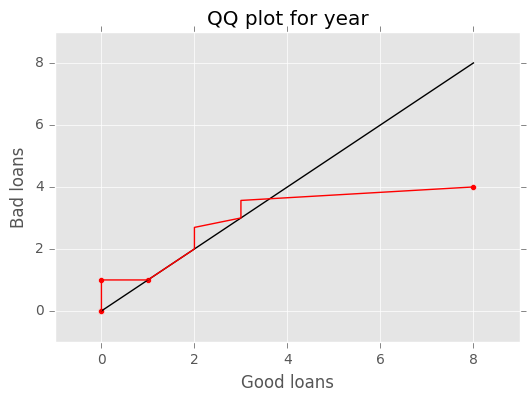

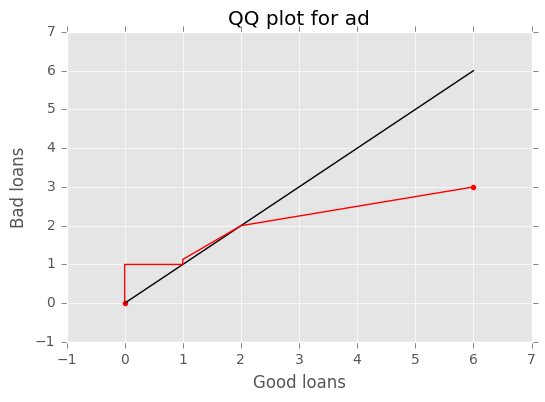

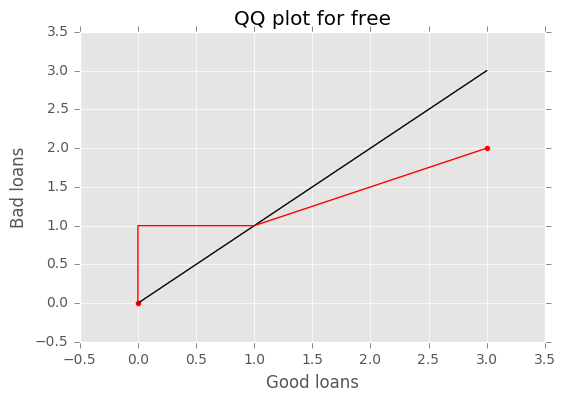

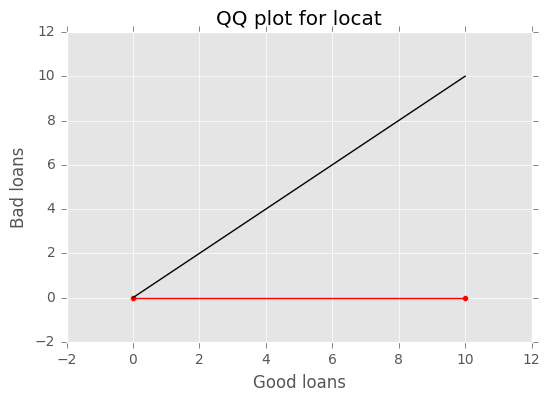

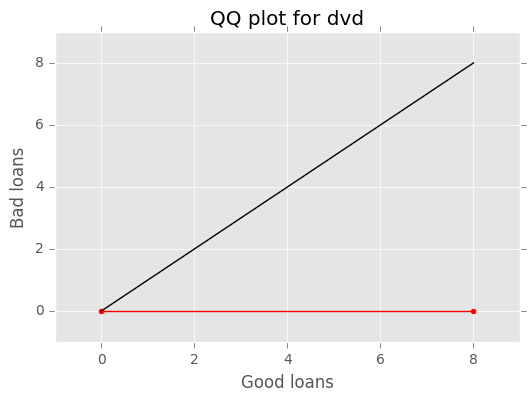

In [412]:
count_cols_qq_data = pd.concat((data_nlp['loan_status'], count_cols_df), axis = 1)
for index in range(1, num_top_diffs / 2):
    good_bad_quantile_plot(count_cols_qq_data, count_cols_qq_data.columns[index])

## Step 3: Model Data

In [413]:
# define model types
log_reg = 2
lda = 3
qda = 4
knn = 5
rf = 6
boost = 7
svm = 8

In [414]:
# function to return name of model type
def get_model_name(model_type):
    if model_type == log_reg:
        model_name = "logistic regression"
    elif model_type == lda:
        model_name = "LDA"
    elif model_type == qda:
        model_name = "QDA"
    elif model_type == knn:
        model_name = "KNN"
    elif model_type == rf:
        model_name = "random forests"
    elif model_type == boost:
        model_name = "boost"
    elif model_type == svm:
        model_name = "SVM"
    else:
        model_name = ""
        
    return model_name

In [415]:
# function to return unfitted model of given type
def get_model_instance(model_type, y):
    default_ratio = (y == True).sum() / float(len(y))
    priors = (default_ratio, 1.0 - default_ratio)
    
    if model_type == log_reg:
         model_instance = Log_Reg(C = 10 ** -6, class_weight = 'balanced',
                                 penalty = 'l2', solver = 'liblinear', fit_intercept = True)
    elif model_type == lda:
        model_instance = LDA(priors = priors)
    elif model_type == qda:
        model_instance = QDA(priors = priors)
    elif model_type == knn:
        model_instance = KNN(n_neighbors = 5)
    elif model_type == rf:
        model_instance = RFC(n_estimators = 10, class_weight = 'balanced',
                            max_features = 'auto', max_depth = None)
    elif model_type == boost:
        model_instance = Boost(n_estimators = 100, max_depth = None, learning_rate = 0.4)
    elif model_type == svm:
        model_instance = SVC(C = 100, kernel = 'poly', degree = 2, class_weight = 'balanced',
                            shrinking = True)
    else:
        model_instance = None
        
    return model_instance

In [416]:
# function to fit and score one model of given type
def fit_and_score_one_model(x, y, model_type):
    n = x.shape[0]
    
    score_accum = 0
    cm_accum = np.zeros((2, 2))
    f1_accum = 0
    num_iters = 3
    for i in range(num_iters):
        mask = np.random.rand(n) < 0.8
     
        x_train = x[mask, :]
        x_test = x[~mask, :]
        
        y_train = y.iloc[mask]
        y_test = y.iloc[~mask]
  
        model = get_model_instance(model_type, y_train)
        model.fit(x_train, y_train)
        y_predict = model.predict(x_test)
        cm_accum += confusion_matrix(y_test, y_predict)
        score_accum += model.score(x_test, y_test)
        f1_accum += f1_score(y_test, y_predict, pos_label = 1)

    # calculate accuracy
    score = score_accum / float(num_iters)
    f1_result = f1_accum / float(num_iters)

    # compute confusion matrix
    cm = cm_accum / float(num_iters)
    #cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm_df = pd.DataFrame(cm, columns = ["Predicted_bad", "Predicted_good"])
    row_labels = pd.DataFrame(["Actual_bad", "Actual_good"])
    cm_df = pd.concat((row_labels, cm_df), axis = 1)
    
    # output results
    model_name = get_model_name(model_type)
    print "Overall accuracy with " + model_name + ":", round(score, 4)
    print
    print "Confusion Matrix:"
    display(cm_df)
    print "F1 score = ", f1_result

### NLP

In [417]:
# KNN 
fit_and_score_one_model(count_cols_bool, data_nlp['loan_status'], knn)

Overall accuracy with KNN: 0.8171

Confusion Matrix:


,0,Predicted_bad,Predicted_good
0,Actual_bad,1481.333333,27.666667
1,Actual_good,305.000000,5.333333


F1 score =  0.0304831575791


In [418]:
# logistic regression 
fit_and_score_one_model(count_cols_bool, data_nlp['loan_status'], log_reg)

Overall accuracy with logistic regression: 0.5655

Confusion Matrix:


,0,Predicted_bad,Predicted_good
0,Actual_bad,859.000000,620.333333
1,Actual_good,150.333333,144.666667


F1 score =  0.27293293027


In [419]:
# logistic regression 
fit_and_score_one_model(data_nlp[['misspell_count', 'desc_len']].values, 
                        data_nlp['loan_status'], rf)

Overall accuracy with random forests: 0.6786

Confusion Matrix:


,0,Predicted_bad,Predicted_good
0,Actual_bad,1160.666667,355.0
1,Actual_good,232.000000,79.0


F1 score =  0.211918280087


In [420]:
# nlp_plus = np.concatenate((count_cols_bool.toarray(), data_nlp[['loan_amount']]), axis = 1)
# fit_and_score_one_model(nlp_plus, data_nlp['loan_status'], log_reg)

In [421]:
# LDA
fit_and_score_one_model(count_cols_bool.toarray(), data_nlp['loan_status'], lda)

Overall accuracy with LDA: 0.1655

Confusion Matrix:


,0,Predicted_bad,Predicted_good
0,Actual_bad,1.666667,1509.333333
1,Actual_good,0.666667,297.666667


F1 score =  0.282827395365


In [422]:
# # use description column with QDA to predict defaults and score accuracy
fit_and_score_one_model(count_cols_bool.toarray(), data_nlp['loan_status'], qda)

Overall accuracy with QDA: 0.529

Confusion Matrix:


,0,Predicted_bad,Predicted_good
0,Actual_bad,758.333333,720.666667
1,Actual_good,126.666667,191.666667


F1 score =  0.289361881566


In [423]:
# random forests 
fit_and_score_one_model(count_cols_bool, data_nlp['loan_status'], rf)

Overall accuracy with random forests: 0.5928

Confusion Matrix:


,0,Predicted_bad,Predicted_good
0,Actual_bad,935.333333,557.666667
1,Actual_good,177.000000,134.000000


F1 score =  0.267170105715


In [424]:
# SVM
fit_and_score_one_model(count_cols_bool, data_nlp['loan_status'], svm)

Overall accuracy with SVM: 0.4905

Confusion Matrix:


,0,Predicted_bad,Predicted_good
0,Actual_bad,672.000000,777.666667
1,Actual_good,117.333333,188.333333


F1 score =  0.293288902672


In [425]:
# boosting
fit_and_score_one_model(count_cols_bool.toarray(), data_nlp['loan_status'], boost)

Overall accuracy with boost: 0.816

Confusion Matrix:


,0,Predicted_bad,Predicted_good
0,Actual_bad,1451.000000,37.333333
1,Actual_good,292.333333,11.000000


F1 score =  0.0621028347783


In [426]:
fit_and_score_one_model(desc_matrix, data_nlp['loan_status'], rf)

Overall accuracy with random forests: 0.7845

Confusion Matrix:


,0,Predicted_bad,Predicted_good
0,Actual_bad,1366.000000,108.0
1,Actual_good,274.666667,27.0


F1 score =  0.123954782488


### Baseline Models

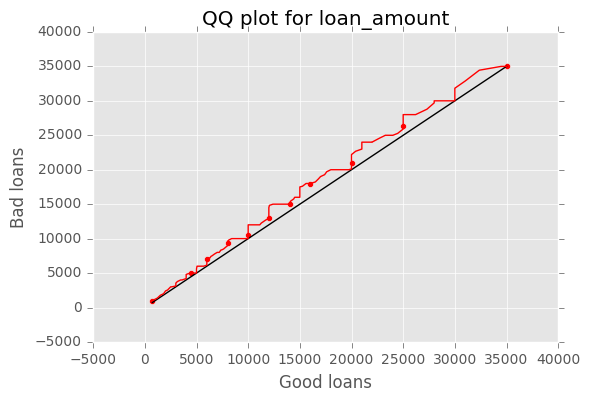

In [427]:
good_bad_quantile_plot(data, 'loan_amount')

In [428]:
# logistic regression
fit_and_score_one_model(data[['loan_amount']].values, data['loan_status'], log_reg)

Overall accuracy with logistic regression: 0.1766

Confusion Matrix:


,0,Predicted_bad,Predicted_good
0,Actual_bad,0.0,4209.666667
1,Actual_good,0.0,902.666667


F1 score =  0.300175662521


In [429]:
# random_forests
fit_and_score_one_model(data[['loan_amount']].values, data['loan_status'], rf)

Overall accuracy with random forests: 0.6042

Confusion Matrix:


,0,Predicted_bad,Predicted_good
0,Actual_bad,2720.000000,1476.000000
1,Actual_good,542.333333,362.666667


F1 score =  0.263885144415


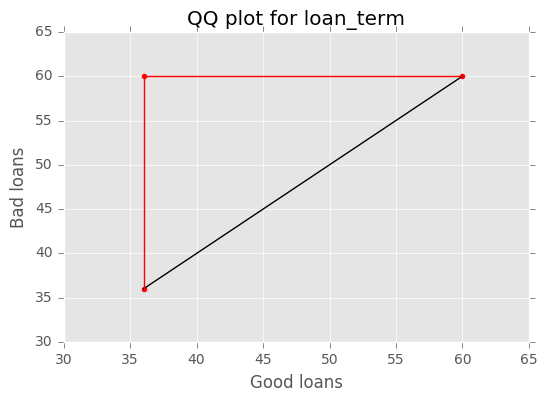

In [430]:
good_bad_quantile_plot(data, 'loan_term')

In [431]:
# random_forests
fit_and_score_one_model(data[['loan_term']].values, data['loan_status'], rf)

Overall accuracy with random forests: 0.7293

Confusion Matrix:


,0,Predicted_bad,Predicted_good
0,Actual_bad,3415.000000,803.000000
1,Actual_good,586.666667,328.333333


F1 score =  0.320767410151


In [432]:
# random_forests
fit_and_score_one_model(data[['loan_amount', 'dti', 'revol_util', 'rir', 
                             'annual_income', 'loan_term']].values, 
                        data['loan_status'], rf)

Overall accuracy with random forests: 0.8123

Confusion Matrix:


,0,Predicted_bad,Predicted_good
0,Actual_bad,4070.000000,84.666667
1,Actual_good,866.333333,44.666667


F1 score =  0.0856243935693


In [433]:
# SVM
# fit_and_score_one_model(data[['loan_amount']].values, data['loan_status'], svm)

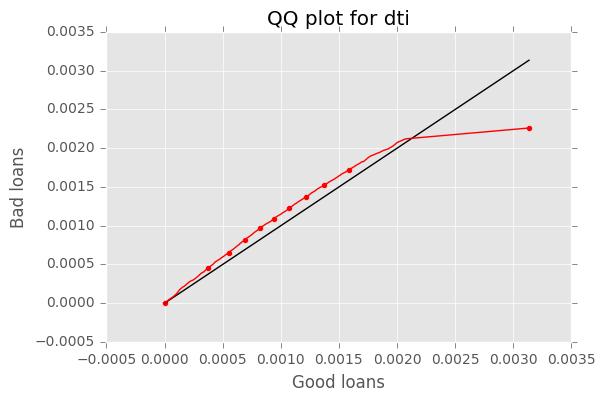

In [434]:
good_bad_quantile_plot(data, 'dti')

In [435]:
# random_forests
fit_and_score_one_model(data[['dti']].values, data['loan_status'], rf)

Overall accuracy with random forests: 0.6782

Confusion Matrix:


,0,Predicted_bad,Predicted_good
0,Actual_bad,3188.000000,935.666667
1,Actual_good,686.333333,231.666667


F1 score =  0.222248612657


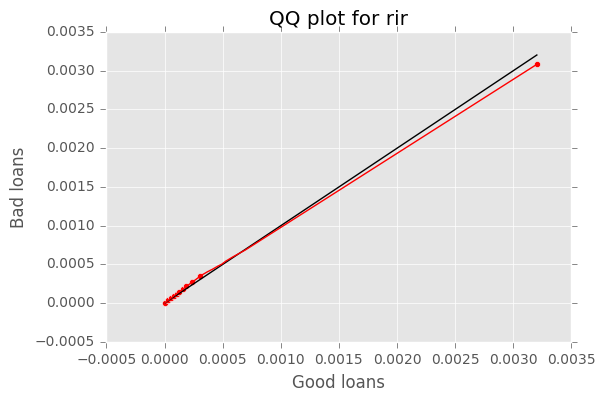

In [436]:
good_bad_quantile_plot(data, 'rir')

In [437]:
# random_forests
fit_and_score_one_model(data[['dti']].values, data['loan_status'], rf)

Overall accuracy with random forests: 0.6708

Confusion Matrix:


,0,Predicted_bad,Predicted_good
0,Actual_bad,3147.333333,998.000000
1,Actual_good,654.666667,220.666667


F1 score =  0.210785872173


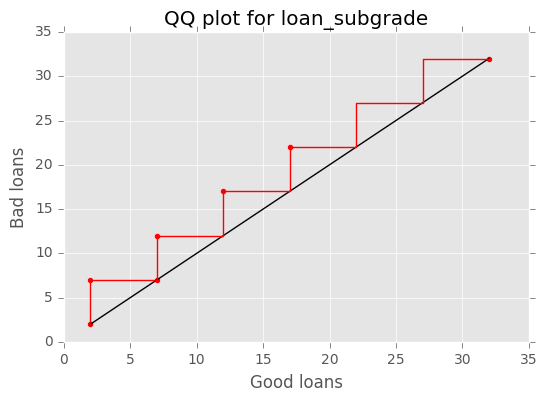

In [438]:
good_bad_quantile_plot(data, 'loan_subgrade')

In [439]:
# random_forests
fit_and_score_one_model(data[['loan_subgrade']].values, data['loan_status'], rf)

Overall accuracy with random forests: 0.5544

Confusion Matrix:


,0,Predicted_bad,Predicted_good
0,Actual_bad,2145.666667,1994.666667
1,Actual_good,238.666667,632.333333


F1 score =  0.361576277552


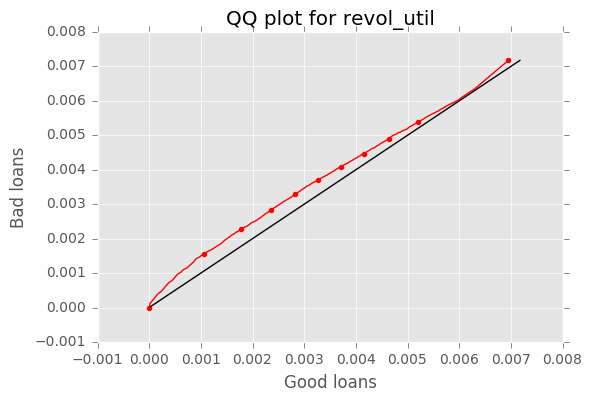

In [440]:
good_bad_quantile_plot(data, 'revol_util')

In [441]:
# random_forests
fit_and_score_one_model(data[['revol_util']].values, data['loan_status'], rf)

Overall accuracy with random forests: 0.6885

Confusion Matrix:


,0,Predicted_bad,Predicted_good
0,Actual_bad,3247.333333,907.000000
1,Actual_good,665.000000,226.666667


F1 score =  0.223891002189


### Stacking

In [442]:
### extract predictors and response
def extract_predictors_response(x, y):
    mask = np.random.rand(x.shape[0]) < 0.8

    x_train = x[mask, :]
    x_test = x[~mask, :]

    y_train = y.values[mask]
    y_test = y.values[~mask]
    
    return x_train, y_train, x_test, y_test

In [443]:
# function to create model stack
def create_model_stack(x, y):
    model_stack = []

    # logistic regression
    model = get_model_instance(log_reg, y)
    model.fit(x, y)
    model_stack.append(model)

#     # QDA
#     model = get_model_instance(qda, y)
#     model.fit(x, y)
#     model_stack.append(model)

#     # KNN
#     model = get_model_instance(knn, y)
#     model.fit(x, y)
#     model_stack.append(model)

    # random forests
    model = get_model_instance(rf, y)
    model.fit(x, y)
    model_stack.append(model)

    # # boosting
    # model = get_model_instance(boost, y)
    # model.fit(x, y)
    # model_stack.append(model)

#     # SVM
#     model = get_model_instance(svm, y)
#     model.fit(x, y)
#     model_stack.append(model)
    
    return model_stack

In [444]:
# function to fit and score a stacking ensemble
def fit_score_stacking(models, x_train, y_train, x_test, y_test, combiner, combiner_name):
    n_train = x_train.shape[0]
    n_test = x_test.shape[0]
    num_models = len(models)
    
    # create variables to hold predictions
    y_train_stack = np.zeros((n_train, num_models))
    y_test_stack = np.zeros((n_test, num_models))
    y_predict = np.zeros(n_test)

    # predict with each model on training and testing data
    for index in range(num_models):
        model = models[index]
        y_train_stack[:, index] = model.predict(x_train)
        y_test_stack[:, index] = model.predict(x_test)

    # predict with ensemble
    combiner.fit(y_train_stack, y_train)
    y_predict = combiner.predict(y_test_stack)
    
    # score with ensemble
    score = combiner.score(y_test_stack, y_test)
    cm = confusion_matrix(y_test, y_predict)
    f1_result = f1_score(y_test, y_predict, pos_label = 1)
    
    # format confusion matrix
    cm_df = pd.DataFrame(cm, columns = ["Predicted_bad", "Predicted_good"])
    row_labels = pd.DataFrame(["Actual_bad", "Actual_good"])
    cm_df = pd.concat((row_labels, cm_df), axis = 1)

    return score, cm_df, f1_result

In [445]:
# fit and score a stacked model for given predictors and response
def try_one_stacked_model(x, y, combiner_type, combiner_name):

    x_train, y_train, x_test, y_test = extract_predictors_response(x, y)

    model_stack = create_model_stack(x_train, y_train)

    combiner = get_model_instance(combiner_type, y_train)

    score, cm_df, f1_result = fit_score_stacking(model_stack, x_train, y_train, 
                                                 x_test, y_test, combiner, combiner_name)

    print
    print "Accuracy with stacking by " + combiner_name + " = " + str(round(score, 4))
    print
    print "Confusion Matrix"
    display(cm_df)
    print
    print "F1 score with stacking by " + combiner_name + " = " + str(round(f1_result, 4))

In [446]:
# fit and score a stacked-model ensemble using NLP features
try_one_stacked_model(count_cols_bool, data_nlp['loan_status'], rf, "random forests")


Accuracy with stacking by random forests = 0.6029

Confusion Matrix


,0,Predicted_bad,Predicted_good
0,Actual_bad,956,534
1,Actual_good,178,125



F1 score with stacking by random forests = 0.2599


In [447]:
# fit and score a stacked-model ensemble using loan amount
try_one_stacked_model(data['loan_amount'].reshape(-1, 1), data['loan_status'], 
                      rf, "random forests")


Accuracy with stacking by random forests = 0.6586

Confusion Matrix


,0,Predicted_bad,Predicted_good
0,Actual_bad,3001,1130
1,Actual_good,589,315



F1 score with stacking by random forests = 0.2682


In [448]:
try_one_stacked_model(desc_matrix, data_nlp['loan_status'], rf, "random forests")


Accuracy with stacking by random forests = 0.7836

Confusion Matrix


,0,Predicted_bad,Predicted_good
0,Actual_bad,1345,120
1,Actual_good,260,31



F1 score with stacking by random forests = 0.1403


In [449]:
nlp_base = np.concatenate((count_cols.toarray(), 
                           data_nlp[['loan_amount', 'annual_income', 'rir',
                                    'revol_util', 'dti', 'loan_term']]), axis = 1)
try_one_stacked_model(nlp_base, data_nlp['loan_status'], log_reg, "logistic regression")


Accuracy with stacking by logistic regression = 0.5375

Confusion Matrix


,0,Predicted_bad,Predicted_good
0,Actual_bad,731,674
1,Actual_good,109,179



F1 score with stacking by logistic regression = 0.3138
